# Blah Blah Blah
*By Kuanlin Chen, PhD student of the schulman lab*

*Advisor: Rebecca Schulman, PhD*

*Johns Hopkins University*

Blah Blah Blah

In [1]:
# Package Importing
import csv, math, os, time, copy, matplotlib, datetime, keras

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from scipy import io as spio
from scipy.ndimage import gaussian_filter
from scipy.stats import bernoulli

from math import log10, floor

from skimage import transform, exposure

print(keras.__version__) # 2.4.3
print(tf.__version__) # 2.2.0

2.4.3
2.2.0


#### Set Up Material Simulation Environment

2.4.3
2.2.0


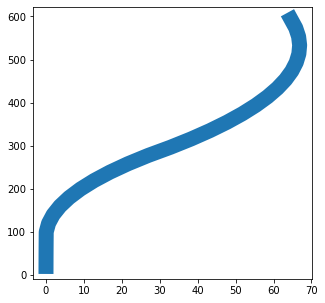

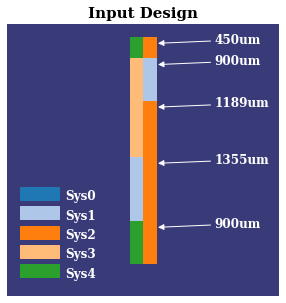

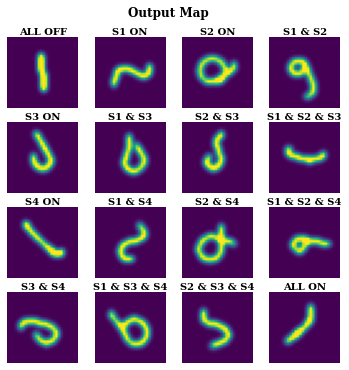

In [2]:
%run ./Numeric_Simulation_of_Material_Behavior_indev.ipynb

In [4]:
# Sample random design
# max_seg = 7
# segment_lengths_ex_four_types = np.random.random(size = (max_seg,)) * 500 + 600
# segment_identities_ex_four_types = np.random.randint(0, high=(4 + 1),size = (2, max_seg))
# print(segment_lengths_ex_four_types)
# print(segment_identities_ex_four_types)

# Sample Design
# 447.00237374  907.26817329 1176.51880725 1355.23921038  894.26759248]
segment_lengths_ex_four_types = [938, 954, 1022, 843, 931, 722, 702, 655, 1066, 947]
segment_identities_ex_four_types = [[2,3,2,3,2,3,4,0,1,4],[4,4,3,1,3,4,4,1,3,2]]
b = ActuatorStrip(segment_lengths_ex_four_types, segment_identities_ex_four_types, four_t_rocs, four_t_ctls)
# a.generate_curves()

# set model for classification
# CNN_dig_v1,  CNN_dig_RSQ2_v1
# a.plot_input_design(save = True)
# print("In the beginning, we started with MNIST trained CNN, but has low accuracy.")
# cnn_digit_model = load_model("CNN_dig_v1.h5")
# a.plot_output_map(score = True, save = False)
# print("We later added strip data to improve accuracy and enable random squiggle identification.")

# cnn_digit_model = load_model("CNN_dig_v1.h5")
# a.plot_input_design(save = False)
# a.plot_output_map(score = False, save = False)
# a.plot_output_map(score = True, save = False)
# print("We further increased the searching space vi`a rotation and mirroring")
# a.plot_input_and_all(rotation = 10, save = False)
# a.plot_input_and_selected(rotation = 20, save = False)
cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")

### Loss Fucntion

In [5]:
def loss_on_dig_sim_var_v2(strip, rotation = 20):
    """
    - loss on digit similarity and variety
    - default 20 rotations
    - Final design score list would be stored in a np array, documenting the max score for each digit.
    - Reconsider np.log as log would greatly lock into one design for a perfect 1 or 7, as log(1-1) = -inf
    
    The loss is then calculated by the following:
    
        digits_for_score = np.log(1 - digit_recs) * 5000 * digits_form)
        loss = np.sum(digits_for_score)

    Where we're taking the log of each value's distance against one, and scaling with the digit numbers that it can form.
    For design that can form more digit number and higher similairy, they can get lower loss.
    """
    strip.analysis(rotation = rotation); output = strip.selected
    dig_score = np.zeros(shape=(10, ))
    
    if output.keys():
        for i in output.keys():
            dig_score[i] = output[i]["score"] 
#     did 1.001 - dig_score as -inf often appears when 1 is in dig_score
    loss = np.sum(np.log(1.001 - dig_score) * 5000 * np.count_nonzero(dig_score))
    
    return loss

loss_on_dig_sim_var_v2(b, rotation = 4) # -2080099.4708855439 if 0, messed up, restart kernal

-2275695.1417187443

**NEw update Function for mutation that limits fab complexity**

In [6]:
def fab_steps_strip_requires(identities):
    top_steps = np.size(np.unique(identities[0]))
    bottom_steps = np.size(np.unique(identities[1]))
    return top_steps + bottom_steps                    

def sp_mutation_maxfab_v1(parent_strip, max_segments, min_segment_length,\
                          max_segment_length, max_fab_steps, rocs, ctls, num_actuator_types):
    """
    - single parent mutation
    - v1 seems to be unable to produce new identities
    - v2 now has 40% new identities chance, and can retain 80% of original genetic info
    """
    # 50% chance in length change
    if np.random.random() < .5:
#         print("length change")
        new_length = np.random.random(size = (max_segments, )) * (max_segment_length - min_segment_length) + min_segment_length
        offspring_strip = ActuatorStrip(new_length, parent_strip.identities, rocs, ctls) 
    # 50% chance in acutator change, mutates 50% of identities
    else:
#         print("idt change")
        satisfy_max_fab = False
        while satisfy_max_fab == False:
            identities_mutation_rate = .5
            sz = int(np.floor(len(parent_strip.identities[0]) * identities_mutation_rate))
            new_identities = copy.deepcopy(parent_strip.identities)
            for i in range(2):
                gene_num = np.random.choice(len(parent_strip.identities[0]), size=(sz,), replace = False)
                new_genes = np.random.choice(num_actuator_types + 1, size = (sz,))
                for j in range(sz): new_identities[i][gene_num[j]] = new_genes[j] 
            if (fab_steps_strip_requires(new_identities) <= max_fab_steps):
                satisfy_max_fab = True
        offspring_strip = ActuatorStrip(parent_strip.segment_lengths, new_identities, rocs, ctls) 

        
    
    return offspring_strip

# b = sp_mutation_v2(a, 100, 600, four_t_rocs, four_t_ctls, 4)
# print(a.identities)
# print(b.identities)
# print(a.segment_lengths)
# print(b.segment_lengths)



In [7]:
def sp_mutation_v2(parent_strip, max_segments, min_segment_length,\
                   rocs, ctls, num_actuator_types):
    """
    - single parent mutation
    - v1 seems to be unable to produce new identities
    - v2 now has 40% new identities chance, and can retain 80% of original genetic info
    """
    # 50% chance in length change
    if np.random.random() < .5:
#         print("length change")
        new_length = np.random.random(size = (max_segments, )) * min_segment_length + min_segment_length
        offspring_strip = ActuatorStrip(new_length, parent_strip.identities, rocs, ctls) 
    # 50% chance in acutator change, mutates 50% of identities
    else:
#         print("idt change")
        identities_mutation_rate = .5
        sz = int(np.floor(len(parent_strip.identities[0]) * identities_mutation_rate))
        new_identities = copy.deepcopy(parent_strip.identities)
        for i in range(2):
            gene_num = np.random.choice(len(parent_strip.identities[0]), size=(sz,), replace = False)
            new_genes = np.random.choice(num_actuator_types + 1, size = (sz,))
            for j in range(sz): new_identities[i][gene_num[j]] = new_genes[j] 
        offspring_strip = ActuatorStrip(parent_strip.segment_lengths, new_identities, rocs, ctls) 
    
    return offspring_strip

# b = sp_mutation_v2(a, 100, 600, four_t_rocs, four_t_ctls, 4)
# print(a.identities)
# print(b.identities)
# print(a.segment_lengths)
# print(b.segment_lengths)



In [8]:
def strip_optimizer_gen_alg_v3(rocs, ctls, loss_function, mutation_function, save_filename,\
                               max_segments = 10, min_segment_length = 600,\
                               max_segment_length = 2000, max_fab_steps = 6,\
                               population_size = 20, generation_limit = 2500):
    """
    Genetic Algorithm for Strip Optimizer
        1. Creates 100 (or 20 for debug) different random initial design.
        2. Score them based on the loss function and get a sum of pupulation score.
        3. Kill 80% of the population who has score in the last 80%.
        4. Mutate the survivor and rescore them.
        5. Goes on and on and on until reaches generation limit
    """        
    def plot_best_fives(population_loss, strip_population, SAVE = False):
        """
        plots 5 best strip design for overall visualization
        """
        best5s = np.argsort(population_loss)[:5]
        for best_num in np.flip(best5s):
                best_strip = strip_population[best_num]
                print("Actuator segments are " + str(best_strip.identities))
                print("Segment lengths are " + str(best_strip.segment_lengths))
                print("Loss is " + str(population_loss[best_num]))
#                 best_strip.plot_input_and_all(rotation = 20, save = False)
                best_strip.plot_input_and_selected(rotation = 20, save = SAVE)

    def save_best_tens(filename, mode, population_loss, strip_population, gen):
        """
        save 10 best strip design of each generation.
        """
        with open(filename, mode) as f:
            f.write("Generation {}\n".format(gen))
            best10s = np.argsort(population_loss)[:10]
            for best_num in np.flip(best10s):
                    best_strip = strip_population[best_num]
                    formed = list(best_strip.selected.keys())
                    f.write("Segments: {}\nIdentities: {}\nFormed: {}\n\n".format(str(best_strip.segment_lengths),str(best_strip.identities),str(formed)))

    itr = 0; num_actuator_types = len(rocs[0][0]) - 1
    # generate initial population
    population_lengths = np.random.random(size = (population_size, max_segments)) * (max_segment_length - min_segment_length) + min_segment_length
    population_identities = np.random.randint(0, high = (num_actuator_types + 1), size = (population_size, 2, max_segments))
    for i in range(population_size):
        found_fabbable = False
        #print("Generating Step " + str(i))
        while found_fabbable == False:
            population_identities[i]=np.random.randint(0, high = (num_actuator_types + 1), size = (2, max_segments))
            if fab_steps_strip_requires(population_identities[i]) <= max_fab_steps:
                found_fabbable = True
               
    strip_population = [ActuatorStrip(population_lengths[num], population_identities[num], four_t_rocs, four_t_ctls) for num in range(population_size)]
    [strip.generate_curves() for strip in strip_population]
    population_loss = [loss_function(strip) for strip in strip_population]
    [strip.save_imgs() for strip in strip_population]

    # plot 5 best individuals for visualization
    plot_best_fives(population_loss, strip_population, SAVE = False)
    # save 5 best individuals
    save_best_tens(save_filename, "w", population_loss, strip_population, itr)
    
    while itr < generation_limit:
        itr += 1
        # evolution and mutation
        print("Evolution {}".format(itr))

        # kills 80% of the population
        survivors = np.argsort(population_loss)[:int(np.floor(population_size/5))]
        print("Survivors: " + str(survivors))
        print("Survivor loss: " + str([population_loss[i] for i in survivors]))
        # mutation and creates 4 offspring for each survivor
        new_population = [mutation_function(strip_population[survivor_id], max_segments, min_segment_length,\
                          max_segment_length, max_fab_steps, 
                          rocs, ctls, num_actuator_types) for survivor_id in survivors for _ in range(4)]
        [strip.generate_curves() for strip in new_population]
        # Add survivors to new population
        [new_population.append(strip_population[survivor_id]) for survivor_id in survivors];
        new_loss = [loss_function(strip) for strip in new_population]
        [strip.save_imgs() for strip in new_population]

        # plot 5 best individuals for visualization
        if itr == generation_limit:
            plot_best_fives(new_loss, new_population, SAVE = True)
        else:
            plot_best_fives(new_loss, new_population, SAVE = False)
            
        save_best_tens(save_filename, "a+", new_loss, new_population, itr)
        print("delta population loss: %.4f"%(np.sum(new_loss)-np.sum(population_loss)))
        population_loss = new_loss; strip_population = new_population
        